# 🧠 Workshop on ActiveInference.jl
### Active Inference Institute – Symposium
#### 13 November 2025

**Authors:**  
- Peter Thestrup Waade  
- Jonathan Ehrenreich Laursen  
- Samuel William Nehrer

# A Multi-Armed Bandit Example 

In [ ]:
# Activate the current Julia project environment
using Pkg
Pkg.activate(".")

In [2]:
# Include external utility functions for the workshop
include("utils.jl"); 

In [3]:
# Load necessary dependencies
using ActiveInference
using Plots
using Distributions

#### ** Multi-Armed Bandit task** (MAB) 


- We imagine an agent facing a slot machine with 3 arms.
- Each arm has a different probability of giving a reward.

**Initially** the slot machine starts with:
- **Arm 1**: Probability of **reward = 0.9** otherwise loss
- **Arm 2**: Probability of **reward = 0.5** otherwise loss
- **Arm 3**: Probability of **reward = 0.1** otherwise loss



After each **25th** trial, these probabilistic **contingencies** between arms and reward/losses **will switch**.

The agent starts **uninformed** about the reward probabilities for each arm.  

Over the course of **100 trials**, it engages with the environment and learns the likely outcome of each arm (while trying to stick to the prefered "reward" outcomes).  




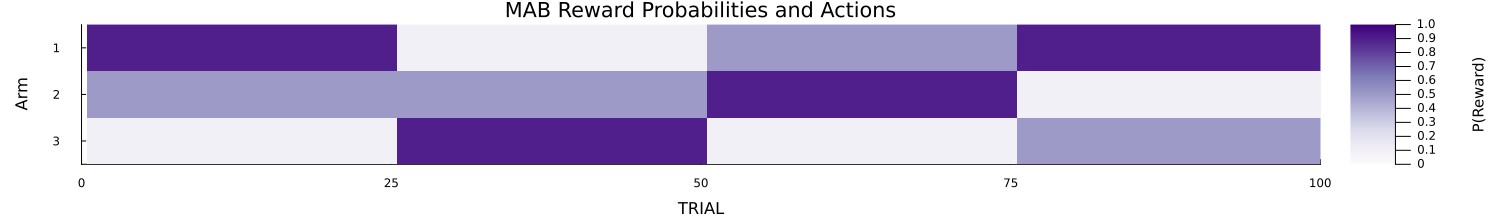

In [4]:
display("image/jpeg", read("environment_probs.jpg"))

### Generative Model Setup

We begin by specifying the structural components of the **generative model**:

- `n_states = [3]` → The model assumes **3 hidden states**, corresponding to the **three possible bandit arms**.
- `n_observations = [2]` → Each interaction can lead to **2 possible observations**: **reward** or **loss**.
- `n_controls = [3]` → The agent has **3 available actions**,  -> **choosing one of the three arms**.
- `policy_length = 1` → Plan only **one move ahead** when making decisions.

In [5]:
n_states = [3] # 3 Bandits 
n_observations = [2] # Reward or Loss 
n_controls = [3] # 3 Arms to pull 
policy_length = 1 

A,B,C,D = create_matrix_templates(n_states, n_observations, n_controls, policy_length, "uniform");

#### Observation Likelihood (A)

The observation likelihood matrix **A** encodes how hidden states (bandit arms) map to observations (reward or loss).  
Columns of the matrix correspond to Arms (1-3), and rows to observations (reward or loss).

| Observation ↓ / Hidden State → | Arm 1 | Arm 2 | Arm 3 |
|:-------------------------------|:------:|:------:|:------:|
| **Reward**                     | 0.5 | 0.5 | 0.5 |
| **Loss**                       | 0.5 | 0.5 | 0.5 |


At initialization, we assume **no knowledge** about which arm is better.


In [6]:
A[1]

2×3 Matrix{Float64}:
 0.5  0.5  0.5
 0.5  0.5  0.5

#### Transition Likelihood (B)

The transition matrices **B** encode the likelihood of transitioning from one arm to another given an action.

**Action 1 — Pull Arm 1**

| Next ↓ / Current → | Arm 1 | Arm 2 | Arm 3 |
|:--------------------|:------:|:------:|:------:|
| **To Arm 1** | 0.82 | 0.82 | 0.82 |
| **To Arm 2** | 0.10 | 0.10 | 0.10 |
| **To Arm 3** | 0.08 | 0.08 | 0.08 |

**Action 2 — Pull Arm 2**

| Next ↓ / Current → | Arm 1 | Arm 2 | Arm 3 |
|:--------------------|:------:|:------:|:------:|
| **To Arm 1** | 0.10 | 0.10 | 0.10 |
| **To Arm 2** | 0.82 | 0.82 | 0.82 |
| **To Arm 3** | 0.08 | 0.08 | 0.08 |

**Action 3 — Pull Arm 3**

| Next ↓ / Current → | Arm 1 | Arm 2 | Arm 3 |
|:--------------------|:------:|:------:|:------:|
| **To Arm 1** | 0.08 | 0.08 | 0.08 |
| **To Arm 2** | 0.10 | 0.10 | 0.10 |
| **To Arm 3** | 0.82 | 0.82 | 0.82 |


In [7]:
# Action 1 
B[1][:,:,1] = [0.82 0.82 0.82; # To arm 1 
               0.10 0.10 0.10; 
               0.08 0.08 0.08]

# Action 2
B[1][:,:,2] = [0.10 0.10 0.10; 
               0.82 0.82 0.82; # To arm 2
               0.08 0.08 0.08]

# Action 3
B[1][:,:,3] = [0.08 0.08 0.08; 
               0.10 0.10 0.10;
               0.82 0.82 0.82]; # To arm 3

#### Preferences (C)

The **C-vector** encodes outcome preferences.

| Observation | Value |
|:-------------|:------:|
| **Reward** | +3.0 |
| **Loss** | −3.0 |

→ The agent strongly prefers **rewards** over **losses**.

In [8]:
C[1] = [3.0, -3.0] # Prefer observation 1 (reward) over observation 2 (loss)

2-element Vector{Float64}:
  3.0
 -3.0

#### Prior over Initial Hidden States (D)

The **D-vector** specifies the belief about the initial state of the bandit.  

| Arm | Probability |
|:---|:-----------|
| Arm 1 | 1.0 |
| Arm 2 | 0.0 |
| Arm 3 | 0.0 |

→ Start at **Arm 1**.

In [9]:
D[1] = [1.0, 0.0, 0.0] # Start at arm 1

3-element Vector{Float64}:
 1.0
 0.0
 0.0

## Defining an Active Inference Model 
---

## 1. Default Implementation

**A)** Ease of Use (classic approach)  

Here, we simply pass the **individual components** to the model constructor.

In [10]:
model = AIFModel(
    A,
    B,
    C = C,
    D = D
);


🧠 Generative Model Information
📋 Model Type:          DiscretePOMDP.NonFactorized
🔍 Abstract Model Type: AbstractGenerativeModel{DiscreteActions, DiscreteObservations, DiscreteStates}
🧩 Components:          A, B, C, D

📊 Structure:
   • Observation modalities: 1
   • State factors: 1
   • States per factor: [3]
   • Observations per modality: [2]

🎮 Control Structure:
   • Controls per factor: [3]
   • Controllable factors: [1]

👁️  Perceptual Process Information

⚙️  Perceptual Process: CAVI

📊 Learning Configuration:
   • Learning enabled: false

🕹️  Action Process Information

🔧  Policy Configuration:
   • Policy length: 2
   • Number of policies: 0
   • Policies provided: false

📊 EFE Calculation Configuration:
   • Use utility: true
   • Use states info gain: true
   • Use parameter info gain: false

🧮 Prior Configuration:
   • Prior over policies (E) provided: false
   • Gamma (precision): 16.0


**B)** Modularity (new, extensible approach)

We define **parts** of the **Active Inference Model** individually in a modular way.

**Generative Model Object**

Create a generative model object from the DiscretePOMDP module which is implemented by default.

In [11]:
generative_model = DiscretePOMDP.GenerativeModel(A=A, B=B, C=C, D=D, verbose=true);


🧠 Generative Model Information
📋 Model Type:          DiscretePOMDP.NonFactorized
🔍 Abstract Model Type: AbstractGenerativeModel{DiscreteActions, DiscreteObservations, DiscreteStates}
🧩 Components:          A, B, C, D

📊 Structure:
   • Observation modalities: 1
   • State factors: 1
   • States per factor: [3]
   • Observations per modality: [2]

🎮 Control Structure:
   • Controls per factor: [3]
   • Controllable factors: [1]


**Perceptual Process**

Create a perceptual process object, which includes:
- An algorithm to perform **inference about hidden states** (Here we use the default CAVI algorithm from the DiscretePOMDP module)
- An algorithm to **update the parameters of the generative model** (Learning; Dirichlet-categorical by default)

In [12]:
perceptual_process = DiscretePOMDP.CAVI(
        A_learning = DiscretePOMDP.Learn_A(concentration_parameter=1.0, forgetting_rate=0.8),
);


👁️  Perceptual Process Information

⚙️  Perceptual Process: CAVI

📊 Learning Configuration:
   • A-parameter learning: true
   • B-parameter learning: false
   • D-parameter learning: false


**Action Process**

Create an action process object:
- This specifies a **planning** algorithm used to **evaluate policies** (Standard inference - no graph used by default in the DiscretePOMDP module)


In [13]:
action_process = DiscretePOMDP.ActionProcess(
    policy_length=policy_length,
    use_states_info_gain=true,
    use_param_info_gain=true,
    use_utility=true
);


🕹️  Action Process Information

🔧  Policy Configuration:
   • Policy length: 1
   • Number of policies: 0
   • Policies provided: false

📊 EFE Calculation Configuration:
   • Use utility: true
   • Use states info gain: true
   • Use parameter info gain: true

🧮 Prior Configuration:
   • Prior over policies (E) provided: false
   • Gamma (precision): 16.0


Collect all three parts in the constructor to create an **Active Inference Model** object

In [14]:
model = AIFModel(
    generative_model = generative_model,
    perceptual_process = perceptual_process,
    action_process = action_process
);

Initialize the MAB environment with:
- reward probability of the best arm: p=0.9
- Switch probabilities after 25 trials

In [15]:
environment = SymposiumUtils.MAB(p=0.9, switch_after=25, seed=42);

In [16]:
# Initial observation and action
observation = [1]
action = [1]

# Run simulation for 100 trials
TRIALS = 100

# Storage vectors to record results 
store_A_matrices = Vector{Vector{Float64}}()
store_posterior_states = Vector{Vector{Float64}}()

Vector{Float64}[]

#### Action-Perception Loop



In [17]:
for trial in 1:TRIALS
    # Do Active Inference
    action_distribution = active_inference(model, observation, action)

    # Sample action from the action distribution
    action = [rand(Categorical(action_distribution.posterior[1]))]

    # Pull arm in the MAB environment
    observation = SymposiumUtils.pull_arm!(environment, action)

    # Store beliefs for plotting later
    push!(store_A_matrices, deepcopy(model.generative_model.A[1][1,:]))
    push!(store_posterior_states, deepcopy(model.perceptual_process.posterior_states[1]))
end

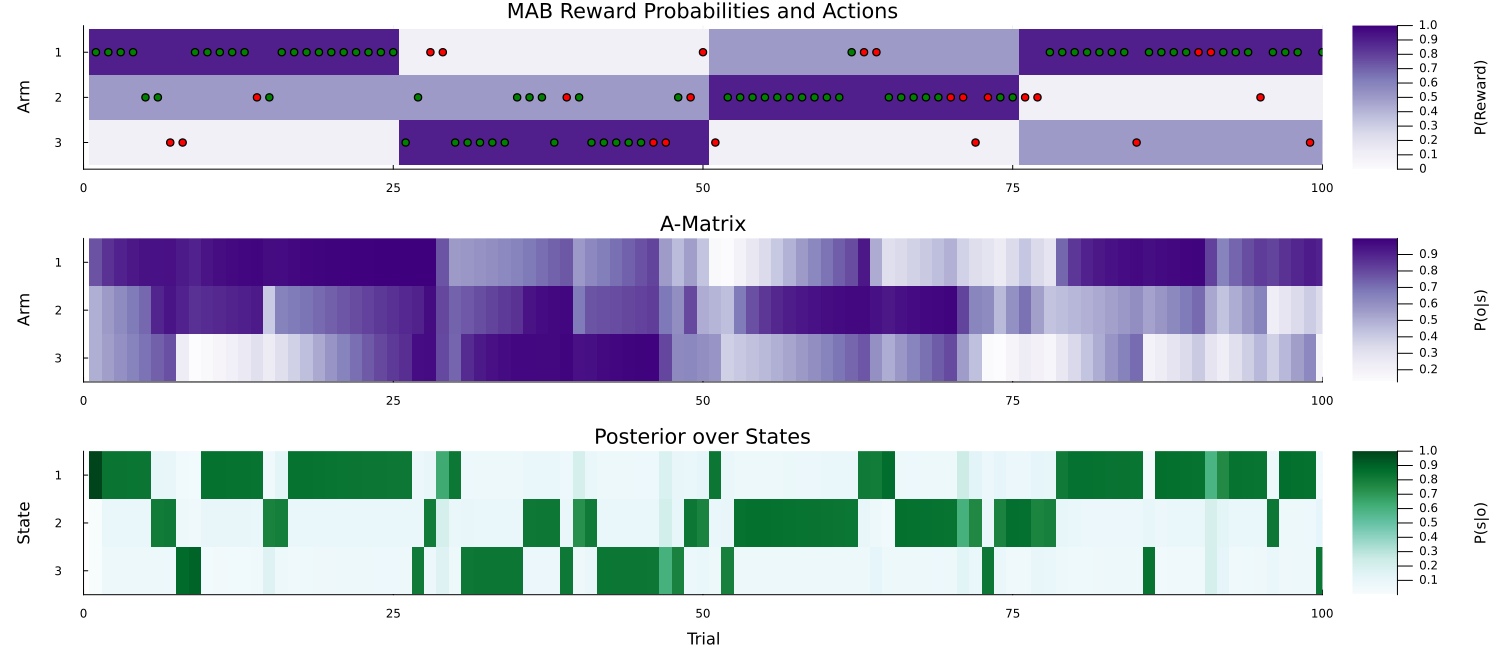

In [18]:
# Plot results
SymposiumUtils.plot_history(environment, store_A_matrices, store_posterior_states)

## 2. Creating a Custom Perceptual Process


We import two components from 'ActiveInference.jl' that we will need to create a custom perceptual process:
- The Abstract Type: **AbstractPerceptualProcess** from the ActiveInferenceCore Module
- The **Learn_A** type implemented in the DiscretePOMDP module.

In [19]:
import ActiveInference.ActiveInferenceCore.AbstractPerceptualProcess 
import ActiveInference.DiscretePOMDP.NonFactorized.Learn_A

In [20]:
mutable struct CustomPerceptualProcess <: AbstractPerceptualProcess
    inference_function::Function # Function to perform inference
    A_learning::Union{Nothing, Learn_A} # Learning algorithm for A matrix

    posterior_states::Union{Vector{Vector{Float64}}, Nothing} # Posterior over states (qs)
    previous_posterior_states::Union{Vector{Vector{Float64}}, Nothing} # Posterior over states from previous time step
    prediction_states::Union{Vector{Vector{Float64}}, Nothing} # Also called an empirical prior 
    observation::Union{Vector{Int}, Nothing} # Current observation
    predicted_states::Union{Vector{Vector{Vector{Vector{Float64}}}}, Nothing} # Expected future states 
    predicted_observations::Union{Vector{Vector{Vector{Vector{Float64}}}}, Nothing} # Expected future observations
    B_learning::Nothing # Learning algorithm for B matrix (we leave this as nothing here)
    D_learning::Nothing # Learning algorithm for D matrix (we leave this as nothing here)

    function CustomPerceptualProcess(; 
        inference_function::Function=nothing, 
        A_learning=nothing
    )
        new(
            inference_function,    # inference_function
            A_learning,            # A_learning
            nothing,               # posterior_states
            nothing,               # previous_posterior_states
            nothing,               # prediction_states
            nothing,               # observation
            nothing,               # predicted_states
            nothing,               # predicted_observations
            nothing,               # B_learning
            nothing                # D_learning
        )
    end
end

**Creating a custom inference function**

As the generative model in our example consists of a single state factor, we can perform exact Bayesian inference as follows:

$$
t = 1 \quad s = \sigma\!\big(\ln D + \ln A^\top\, o\big)
$$

$$
t > 1 \quad s = \sigma\!\big(\ln empirical\_prior + \ln A^\top\, o\big)
$$

In [21]:
# Import softmax function from LogExpFunctions package
using LogExpFunctions: softmax

In [22]:
function exact_inference(model::AIFModel, prior, observation)
    # Deep copy of the A matrix to avoid modifying the original
    A_n = deepcopy(model.generative_model.A)
    # Get the index of the observation
    obs_idx = findfirst(x -> x == 1.0, observation[1])

    # Calculate log likelihood and log prior 
    log_likelihood = log.(A_n[1][obs_idx,:] .+ 1e-16)
    log_prior = log.(prior[1] .+ 1e-16)

    # Compute posterior
    qs = [softmax(log_likelihood .+ log_prior, dims=1)]

    return qs
end

exact_inference (generic function with 1 method)

**Create the Active Inference Model Object**

In [27]:
model = AIFModel(
    # Define the DiscretePOMDP generative model object
    generative_model = DiscretePOMDP.GenerativeModel(A=A, B=B, C=C, D=D, verbose=true), 

    # We use our custom perceptual process here
    perceptual_process = CustomPerceptualProcess(
        inference_function = exact_inference, # The inference function we defined above
        A_learning = Learn_A(concentration_parameter=1.0, forgetting_rate=0.8)),

    # Define the action process as before
    action_process = DiscretePOMDP.ActionProcess(
        policy_length=1,
        use_param_info_gain=true)
);


🧠 Generative Model Information
📋 Model Type:          DiscretePOMDP.NonFactorized
🔍 Abstract Model Type: AbstractGenerativeModel{DiscreteActions, DiscreteObservations, DiscreteStates}
🧩 Components:          A, B, C, D

📊 Structure:
   • Observation modalities: 1
   • State factors: 1
   • States per factor: [3]
   • Observations per modality: [2]

🎮 Control Structure:
   • Controls per factor: [3]
   • Controllable factors: [1]

🕹️  Action Process Information

🔧  Policy Configuration:
   • Policy length: 1
   • Number of policies: 0
   • Policies provided: false

📊 EFE Calculation Configuration:
   • Use utility: true
   • Use states info gain: true
   • Use parameter info gain: true

🧮 Prior Configuration:
   • Prior over policies (E) provided: false
   • Gamma (precision): 16.0


**Re-initialize everything again**

In [28]:
# Initial observation and action
observation = [1]
action = [1]

# Run simulation for 100 trials
TRIALS = 100

# Storage vectors to record results 
store_A_matrices = Vector{Vector{Float64}}()
store_posterior_states = Vector{Vector{Float64}}()

Vector{Float64}[]

**Run Simulation with the custom inference function**

In [29]:
for trial in 1:TRIALS
    # Perform Active Inference  
    action_distribution = active_inference(model, observation, action)

    # Sample action from the action distribution
    action = [rand(Categorical(action_distribution.posterior[1]))]

    # Pull arm in the MAB environment
    observation = SymposiumUtils.pull_arm!(environment, action)

    # Store beliefs for plotting later
    push!(store_A_matrices, deepcopy(model.generative_model.A[1][1,:]))
    push!(store_posterior_states, deepcopy(model.perceptual_process.posterior_states[1]))
end

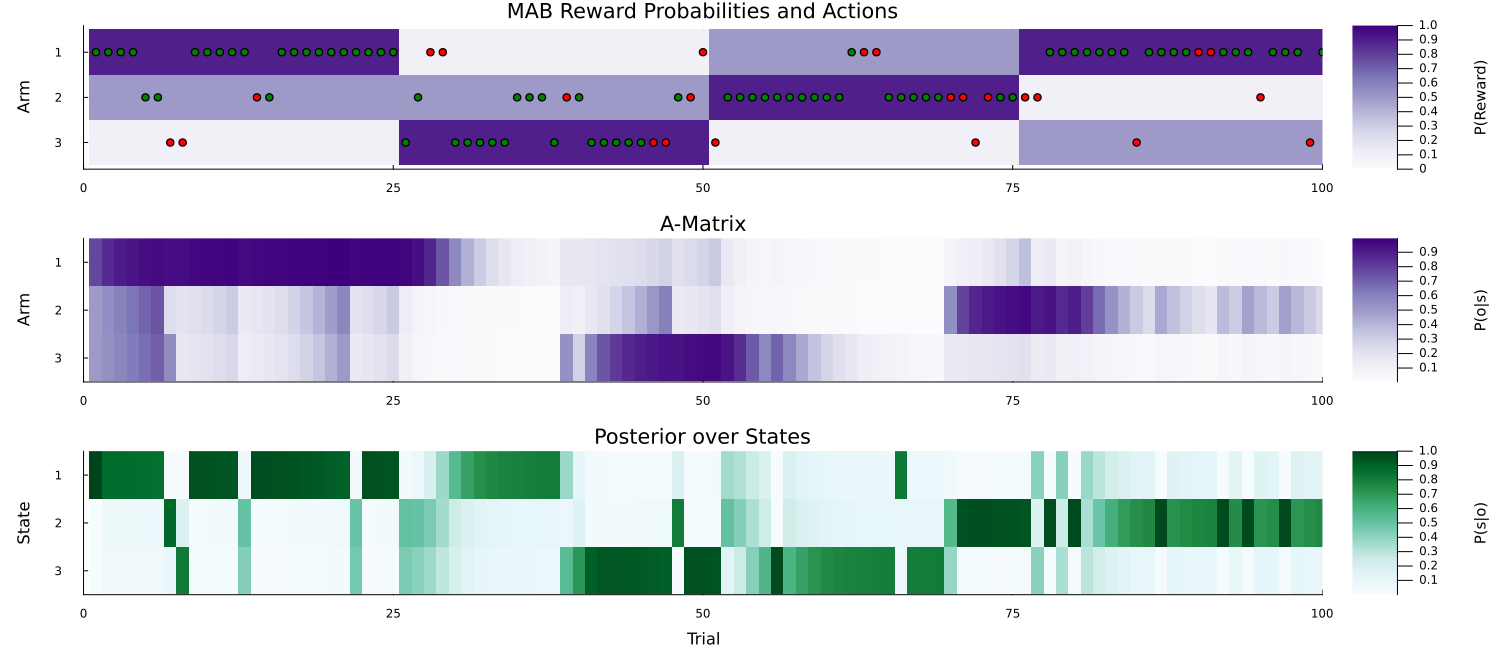

In [30]:
# Plot results
SymposiumUtils.plot_history(environment, store_A_matrices, store_posterior_states)


## 3. Using PPLs as parts of the Active Inference model 

By following the same steps as before, we can use a PPL such as Turing.jl to perform inference over the hidden states.

In [31]:
# Bring Turing into scope
using Turing

In [32]:
# Define inference function using Turing.jl
function turing_perception(model::AIFModel, prior, observation)
    # Deep copy of the A matrix to avoid modifying the original
    A_n = deepcopy(model.generative_model.A)
    # Get the index of the observation
    obs_idx = findfirst(x -> x == 1.0, observation[1])

    # The likelihood is given by the A matrix
    likelihood = A_n[1]

    # Define the Turing model
    turing_model = Turing.@model function _turing_model(prior, likelihood, obs_idx)
        # The hidden state is a categorical variable
        state ~ Categorical(prior[1])               
        # The observation is drawn from the likelihood conditional the state        
        obs_idx ~ Categorical(vec(likelihood[:, state])) 
    end        
    # Sample from the posterior using Metropolis-Hastings with 5000 samples
    chain = sample(_turing_model(prior, likelihood, obs_idx), MH(), 5000)
    # Take the mean of the posterior samples to get the posterior distribution over states
    posterior_states = [mean(chain[:state] .== i) for i in 1:3]

    # Return the posterior distribution over states
    return [posterior_states]
end

turing_perception (generic function with 1 method)

**Re-define the Active Inference Model Object with Turing Inference**

In [41]:
model = AIFModel(
    # Define the DiscretePOMDP generative model object
    generative_model = DiscretePOMDP.GenerativeModel(A=A, B=B, C=C, D=D, verbose=true), 

    # We can use our custom perceptual process object again, but with Turing inference function
    perceptual_process = CustomPerceptualProcess(
        inference_function = turing_perception, # The Turing inference function defined above
        A_learning = Learn_A(concentration_parameter=1.0, forgetting_rate=0.8)),

    # Define the action process as before
    action_process = DiscretePOMDP.ActionProcess(
        policy_length=1,
        use_param_info_gain=true)
);

**Re-Initialize everything again**

In [42]:
# Initial observation and action
observation = [1]
action = [1]

# Run simulation for 100 trials
TRIALS = 100

# Storage vectors to record results 
store_A_matrices = Vector{Vector{Float64}}()
store_posterior_states = Vector{Vector{Float64}}()

Vector{Float64}[]

**Run simulation with Turing model as perceptual process**

In [43]:
for trial in 1:TRIALS
    # Perform Active Inference  
    action_distribution = active_inference(model, observation, action)

    # Sample action from the action distribution
    action = [rand(Categorical(action_distribution.posterior[1]))]

    # Pull arm in the MAB environment
    observation = SymposiumUtils.pull_arm!(environment, action)

    # Store beliefs for plotting later
    push!(store_A_matrices, deepcopy(model.generative_model.A[1][1,:]))
    push!(store_posterior_states, deepcopy(model.perceptual_process.posterior_states[1]))
end

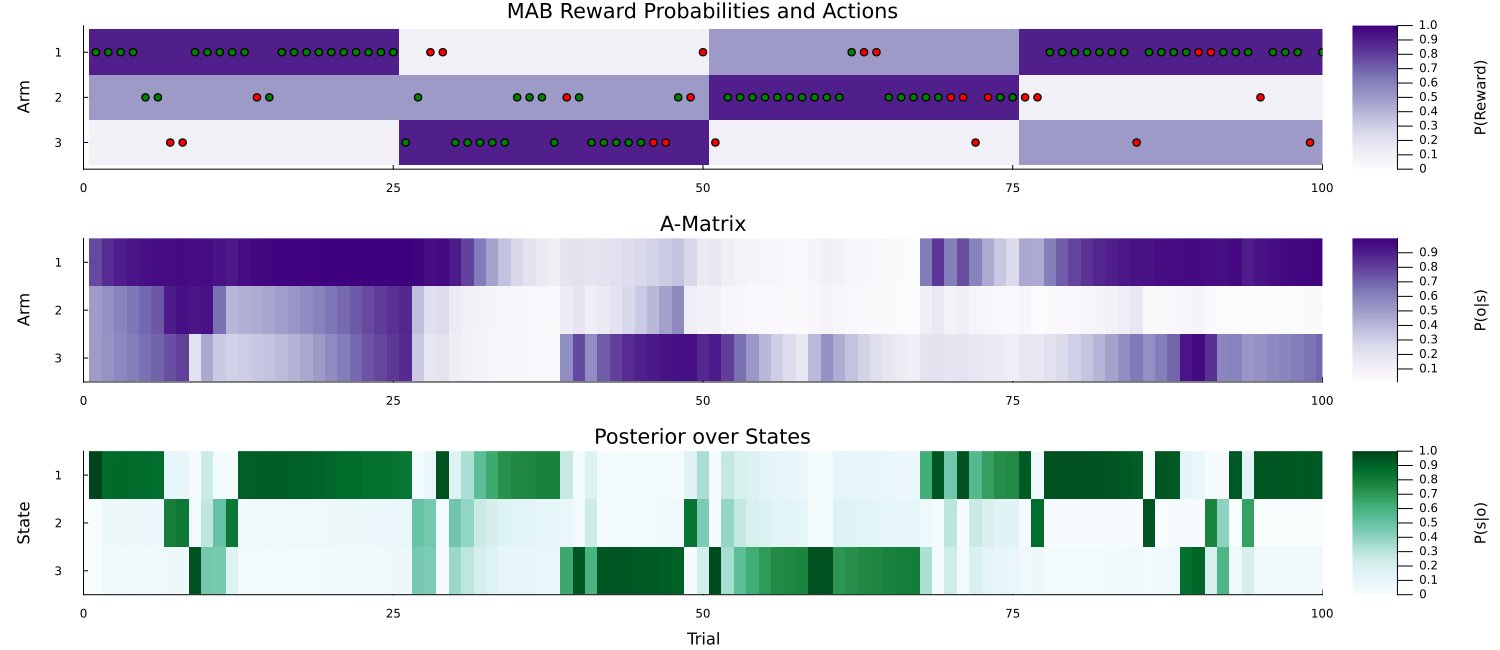

In [44]:
# Plot results
SymposiumUtils.plot_history(environment, store_A_matrices, store_posterior_states)


--- 

--- 

---